In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob
# from scipy.stats import linregress
from shapely.geometry import Polygon
from scipy.special import erf
from scipy.optimize import curve_fit 
from seaborn import regplot
# import matplotlib.image as mpimg
import cv2
from scipy.integrate import odeint
# from matplotlib.colors import hsv_to_rgb
from simplefit import fit # https://gist.github.com/aminnj/37ab33533b07b7007623ae278c5d5797
import uncertainties
from uncertainties import unumpy
import circle_fit
import geopandas as gpd
from lmfit import minimize, Parameters, Parameter, report_fit
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from uncertainties import ufloat

In [3]:
g = 9.81 # m/s2, gravity
beta = 1e-4 # degC-1, thermal coefficient expansion water
deltaT = 20.5 # degC, melting-ambient
alpha = 0.133e-6 # m2/s, thermal diffiusivity water
#alpha = 1.02e-6 # m2/s, thermal diffiusivity ice
nu = 1.4e-6 # m2/s, kinematic viscosity water
Pr = 10 # variable
kappa = 580e-3 # W/Km, thermal conductivity water
T_in = 16 # degC, initial negative temperature ice
rho_ice = 917 # kg/m3, density ice
L_f = 334e3 # J/kg, latent heat fusion water
c_s = 4186 # J/kgK, specific heat water 

def pickFromDistr(mean,std):
    pick = np.random.normal(mean,std)
    return pick
def bootstrap(result):
    bsParams = np.zeros(len(result['params']))
    for ip,param in enumerate(result['params']):
        # print(result['params'][param])
        bsParams[ip] = pickFromDistr(result['params'][param]['value'],result['params'][param]['error'])
    return bsParams

def uNu_areas(A,T_water, dt):
    """Returns an approximated value of the Nusselt number that accounts for the latent and sensitive heat.
    The parameter passed is the area of the cylinder. 

    Args:
        A (float): area of cylinder [m2]
        T_water (float): bulk water temperature [degC]
        dt (float): time interval [s]

    Returns:
        float: value of Nusselt number
    """   
    h = -(ugradient(A)/dt)*rho_ice*(L_f+c_s*T_in)/(np.pi*T_water)
    return h/kappa

def ugradient(uarr):
    ytop = unumpy.nominal_values(uarr)+unumpy.std_devs(uarr)
    ybottom = unumpy.nominal_values(uarr)-unumpy.std_devs(uarr)
    gradient = np.gradient(unumpy.nominal_values(uarr))
    maxgradient = ytop[:-1]-ybottom[1:]
    mingradient = ybottom[:-1]-ytop[1:]
    sigmagradient = maxgradient-mingradient
    return unumpy.uarray(gradient[:-1],sigmagradient)

def polynomial_fitting(xdata,ydata,degree,boolPlot):
    """Fits a polynomial to data. 

    Args:
        xdata (np.array/list): data that will be on x axis
        ydata (np.array/list): data to be fitted (on y axis)
        degree (int): degree of polynomial
        boolPlot (bool): wheter to plot a line with the output or not
    Returns:
        np.array: parameters of best fitting function
        np.poly1d: polynomial element of numpy
    """    
    fit_par = np.polyfit(xdata, ydata,degree)
    yfit = np.poly1d(fit_par)
    if boolPlot: plt.plot(xdata, yfit(xdata),c='k',linestyle='--')
    return fit_par,yfit

def running_mean(x,N):
    """Function that returns the running mean on the array x with window N

    Args:
        x (np.array): input array
        N (int): window size

    Returns:
        np.array: averaged array (len = len(x)-N+1)
    """    
    return np.convolve(x, np.ones(N)/N, mode='valid')

def sigmoid_fitting(xdata,ydata,exp_y0,boolPlot):
    """Fits a sigmoid function (sigmoid) to data. 

    Args:
        xdata (np.array/list): data that will be on x axis
        ydata (np.array/list): data to be fitted (on y axis)
        exp_y0 (float): known (experimental) value for the ydata[0]
        boolPlot (bool): wheter to plot a line with the output or not
    Returns:
        np.array: best fitting function
    """    
    p0 = [-ydata[0], xdata[-1]/2,exp_y0*1e2/xdata[-1],ydata[0]] 
    popt, _ = curve_fit(sigmoid, xdata, ydata,p0,maxfev=int(1e5))
    if boolPlot: plt.plot(xdata, sigmoid(xdata,popt[0],popt[1],popt[2],popt[3]),c='k',linestyle='--')
    return sigmoid(xdata,popt[0],popt[1],popt[2],popt[3])

def sigmoid(x, L ,x0, k, b):
    """Returns a sigmoid function 

    Args:
        x (np.array): input array
        L (float): function parameter
        x0 (float): function parameter
        k (float): function parameter
        b (float): function parameter

    Returns:
        np.array: output array
    """    
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def gauss(x, H, A, x0, sigma): 
    """Returns a gaussian function

    Args:
        x (np.array): input array
        H (float): function parameter
        A (float): function parameter
        x0 (float): function parameter
        sigma (float): function parameter

    Returns:
        np.array: output array
    """    
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.
    https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def correct_outliers(y,precision=0.1):
    """Corrects outliers by interpolating between them. Outliers are defined where there is a change of more than a certain fraction in the normalised gradient. 
    This function can only handle one outlier.

    Args:
        y (np.array): input array
        precision (float) : between 0 and 1, max allowed change in the gradient

    Returns:
        np.array: array without outliers.
    """    
    outliers = np.where(abs(np.gradient(y/y[0]))>precision)[0]
    if len(outliers)>1:
        # only works if there is one outlier
        y[np.mean(outliers,dtype=int)] = np.nan
        y = np.array(y)
        nans,x = nan_helper(y)
        y[nans] = np.interp(x(nans),x(~nans),y[~nans])
    return y

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def rotate(points, origin, degrees):
    """Rotates a polygon (list of x,y-coordinates) about an origin of an angle in degrees

    Args:
        points (np.array/list): points coordinates
        origin (np.array/list): coordinate center of rotation
        degrees (float): degrees of rotation

    Returns:
        np.array: coordinates of rotated points
    """    
    radians = np.deg2rad(degrees)
    x,y = points[:,0],points[:,1]
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = np.cos(radians)
    sin_rad = np.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y
    return np.vstack((qx, qy)).T

def PolyArea(x,y):
    """Returns area of a polygon given the x,y-coordinates of its points

    Args:
        x (np.array): x-coordinates
        y (np.array): y-coordinates

    Returns:
        _type_: _description_
    """    
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def Kell_rho(T):
    """Returns density of PURE water at temperature T according to the Kell function (5th order polynomial fit)

    Args:
        T (float): temperature [degC]

    Returns:
        float: density of water [kg/m3]
    """    
    a = -2.8054253e-10
    b = 1.0556302e-7
    c = -4.6170461e-5
    d = -0.0079870401
    e = 16.945176
    f = 999.83952
    g = 0.01687985
    rho = (((((a*T+b)*T+c)*T+d)*T+e)*T+f) / (1+g*T)
    return rho

def MH_rho(T,S=0):
    """Returns density of salty water at temperature T, with salinity S according to the formula in Millero, Huang,2009. 
    That formula is calculates the additional density due to the salts. The pure water density is calculated from the Kell formula. 

    Args:
        T (float): temperature [degC]
        S (float): water salinity [g/l], Defaults to 0 g/l.

    Returns:
        float: density of water [kg/m3]
    """   
    a0,a1,a2,a3,a4,a5 = 8.211458E-01,-3.959680E-03,7.305182E-05,-8.282446E-07,5.386657E-09,0
    A = a0 + a1*T + a2*T**2 + a3*T**3 + a4*T**4 + a5*T**5
    b0,b1,b2 = -6.058307E-03,8.265457E-05,-1.077747E-06
    B = b0 + b1*T + b2*T**2
    C = 5.265280E-04
    rho = A*S + B*S**1.5 + C*S**2 + Kell_rho(T)
    return rho

def uNu_fit(params,t,r0,T_water):
    # if len(params) != 3: return
    a = ufloat(params['a']['value'],params['a']['error'])
    b = ufloat(params['b']['value'],params['b']['error'])
    c = ufloat(params['c']['value'],params['c']['error'])
    rrdot = c*r0 + c**2*t + 2*b*r0*t + 3*b*c*t**2 + 3*a*r0*t**2 + 2*b**2*t**3 + 4*a*c*t**3 + 5*a*b*t**4 + 3*a**2*t**5
    Adot = 2*np.pi*rrdot # the dt is already included in the fit
    h = -(Adot)*rho_ice*(L_f+c_s*T_in)/(np.pi*T_water)
    return h/kappa

def Nu_areas(A,T_water, dt):
    """Returns an approximated value of the Nusselt number that accounts for the latent and sensitive heat.
    The parameter passed is the area of the cylinder. 

    Args:
        A (float): area of cylinder [m2]
        T_water (float): bulk water temperature [degC]
        dt (float): time interval [s]

    Returns:
        float: value of Nusselt number
    """   
    h = -(np.gradient(A)/dt)*rho_ice*(L_f+c_s*T_in)/(np.pi*T_water)
    return h/kappa

    # different version that considers perimeter (it doesn't change much...)
    # h = -(np.gradient(A)/dt)*rho_ice*(L_f+c_s*T_in)/(T_water*(np.sqrt(A)+2*A))
    # return h*np.sqrt(A)/kappa

def Ra(r,T1,T2):
    """Calculates Rayleigh number for a cylinder in water, given radius and two temperatures. The density is calculated according to the Kell's formula.

    Args:
        r (float): cylinder's radius [m]
        T1 (float): temperature 1 [degC]
        T2 (float): temperature 2 [degC]

    Returns:
        float: Rayleigh number
    """    
    Tavg = np.mean([T1,T2])
    rho = Kell_rho(Tavg)
    deltaRho = abs(Kell_rho(T1)-Kell_rho(T2))
    return g*deltaRho*(2*r)**3/(alpha*nu*rho)

def Ra_salinity(r,T1,T2,S=0):
    """Calculates Rayleigh number for a cylinder in (possibly salty) water, given radius,salinity, and two temperatures. 
    The density is calculated according to Millero and Huang, 2009.

    Args:
        r (float): cylinder's radius [m]
        S (float,optional): water salinity [g/l], Defaults to 0 g/l.
        T1 (float): temperature 1 [degC]
        T2 (float): temperature 2 [degC]

    Returns:
        float: Rayleigh number
    """    
    T_min = min(T1,T2)
    T_max = max(T1,T2)
    rho1 = MH_rho(T_min,S=0) # fresh, cold water
    rho2 = MH_rho(T_max,S=S)
    rho_avg = np.mean((rho1,rho2))

    deltaRho = abs(rho1-rho2)
    return g*deltaRho*(2*r)**3/(alpha*nu*rho_avg)

def Ra_heavyWater(r,T1):
    """Calculates Rayleigh number for a heavy water cylinder in fresh water, given radius and the temperature of the "light" water. The heavy water is assumed to be at 0degC.
    The density is calculated according to Millero and Huang, 2009.

    Args:
        r (float): cylinder's radius [m]
        T1 (float): temperature of bulk [degC]

    Returns:
        float: Rayleigh number
    """    
    rho1 = MH_rho(T1,S=0) # bulk water
    rho2 = 1106 # heavy water melt
    rho_avg = np.mean((rho1,rho2))

    deltaRho = abs(rho1-rho2)
    return g*deltaRho*(2*r)**3/(alpha*nu*rho_avg)

def Nu(Ray):
    """Calculates Nusselt number for a cylinder in water given Rayleigh number and Prandtl number (not function variable). Formula from Churchill and Chu, 1975

    Args:
        Ray (float): Rayleigh number

    Returns:
        float: Nusselt number
    """    
    return (0.6 + (0.387*Ray**(1/6)) / ( ( 1 + (0.559/Pr)**(9/16) ) ** (16/9) ) )**2 

def h(Nu,r):   
    return kappa*Nu/(2*r)

def drdt(h,r,t):
    T_0 = -T_in
    T_star = T_0 + (deltaT-T_0)*.5*erf(r/np.sqrt(alpha*t))
    dT_stardt = (deltaT-T_0)*.5 * np.exp(-r**2/(alpha*t)) / np.sqrt(alpha*t)
    return -(h*deltaT+kappa*dT_stardt)/(rho_ice*(L_f+c_s*(-T_star)))

def evolution(r_0):
    timesteps = 1600 #s
    radii = [r_0,]
    r = r_0
    for timestep in range(1,timesteps):
        # timestep is in seconds
        Ra_ = Ra(r,-16,20)
        Nu_ = Nu(Ra_)
        h_ = h(Nu_,r)
        drdt_ = drdt(h_,r,timestep)
        # print(Ra_,Nu_,h_,drdt_)
        r = r + drdt_
        radii.append(r)
    return radii

def makePolygonBelow(polygon, level):
    """Draws the part of a polygon which is below a horizontal level. Returns a list of coordinates. 

    Args:
        polygon (np.array): polygon coordinates
        level (float): horizontal level 

    Returns:
        np.array: coordinates of polygon below level
    """    
    newY = np.where(polygon[:,1]<level,polygon[:,1],level)
    polygonBELOW = polygon.copy()
    polygonBELOW[:,1] = newY
    return polygonBELOW



def findWL(polygon, densityRatio=.917, epsilon = 0.001):
    """Finds the water level for an ice polygon immersed in water, with prescribed precision. 

    Args:
        polygon (np.array): polygon coordinates
        densityRatio (float, optional): density ratio of the two fluids. Defaults to .917, ratio of ice/fresh water.
        epsilon (float, optional): precisio of calculation. Defaults to 0.001.

    Returns:
        float: water level of the immersed polygon
    """    
    originalArea = PolyArea(polygon[:,0],polygon[:,1])
    ymin, ymax = min(polygon[:,1]),max(polygon[:,1])
    mmin, mmax = ymin,ymax
    attempt = ymin + (ymax-ymin) * densityRatio 
    pgbelow = makePolygonBelow(polygon,attempt)
    # plt.plot(pgbelow[:,0],pgbelow[:,1],label='initial attempt')

    newArea = PolyArea(pgbelow[:,0],pgbelow[:,1])

    ratio = newArea/originalArea

    while abs(ratio-densityRatio) > epsilon:
        if ratio-densityRatio > 0:
            mmax = attempt
        else:
            mmin = attempt
        attempt = (mmin+mmax)/2
        pgbelow_ = makePolygonBelow(polygon,attempt)
        newArea_ = PolyArea(pgbelow_[:,0],pgbelow_[:,1])
        ratio = newArea_/originalArea
        # print(f'{newArea_:.2f}',ratio)

    return attempt

def hydrostasy(contour,densityRatio=.917):
    """Returns center of mass and center of buoyancy for an immersed polygon.

    Args:
        contour (np.array): coordinates of polygon.
        densityRatio (float, optional): density ratio of the two fluids. Defaults to .917, ratio of ice/fresh water.

    Returns:
        tuple: (center of mass, center of buoyancy)
    """    
    polygon = Polygon(contour)
    com = polygon.centroid
    del polygon
    immersedPG = makePolygonBelow(contour,findWL(contour,densityRatio=densityRatio))
    polygon = Polygon(immersedPG)
    cob = polygon.centroid
    return com,cob

## Fitting stuff to radii

20.5
20.9


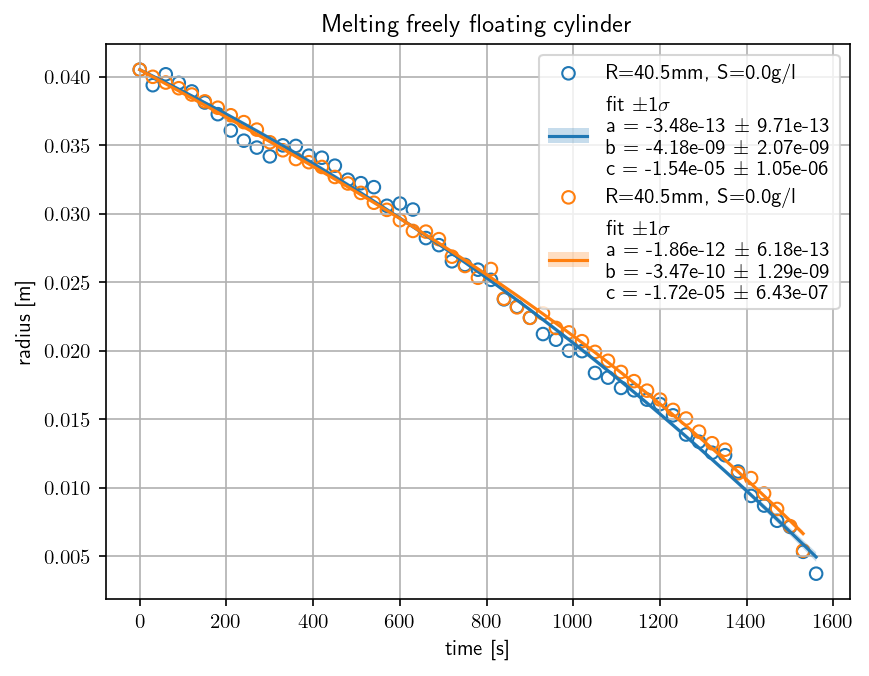

In [4]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd','2023-12-15/1st','2023-12-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-12-01/2nd','2023-12-04/1st']# D2O

myColours = np.repeat(['tab:blue','tab:orange','green','purple','red','cyan','brown','pink','grey','olive',
                       'black','lime'],1)

plt.figure(dpi=150)
plt.rcParams['text.usetex'] = True

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10
        
    if exp_radius!=0.0405: continue
    if exp_sal!=0.: continue

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)
    
    radii = correct_outliers(radii)

    plt.scatter(contours_per_shot*interval*np.arange(len(radii)),radii,
                label=f'R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l',
                edgecolors=myColours[ic],facecolors='none') # one shot every 30 seconds
    
    # _ = sigmoid_fitting(contours_per_shot*interval*np.arange(len(radii)),radii,exp_y0=exp_radius,boolPlot=1)
    # _, _ = polynomial_fitting(contours_per_shot*interval*np.arange(len(radii)),radii,degree=3,boolPlot=1)
    x = contours_per_shot*interval*np.arange(len(radii))
    res, sigma = fit(func=f'np.polyval([a,b,c,{radii[0]}],x)',xdata=x[:],ydata=radii[:],color=myColours[ic],boolRetSigmas=True,legend=False,draw=1)
    print(exp_wt)

plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('radius [m]')
plt.title('Melting freely floating cylinder')
plt.show()

# Nusselt vs time

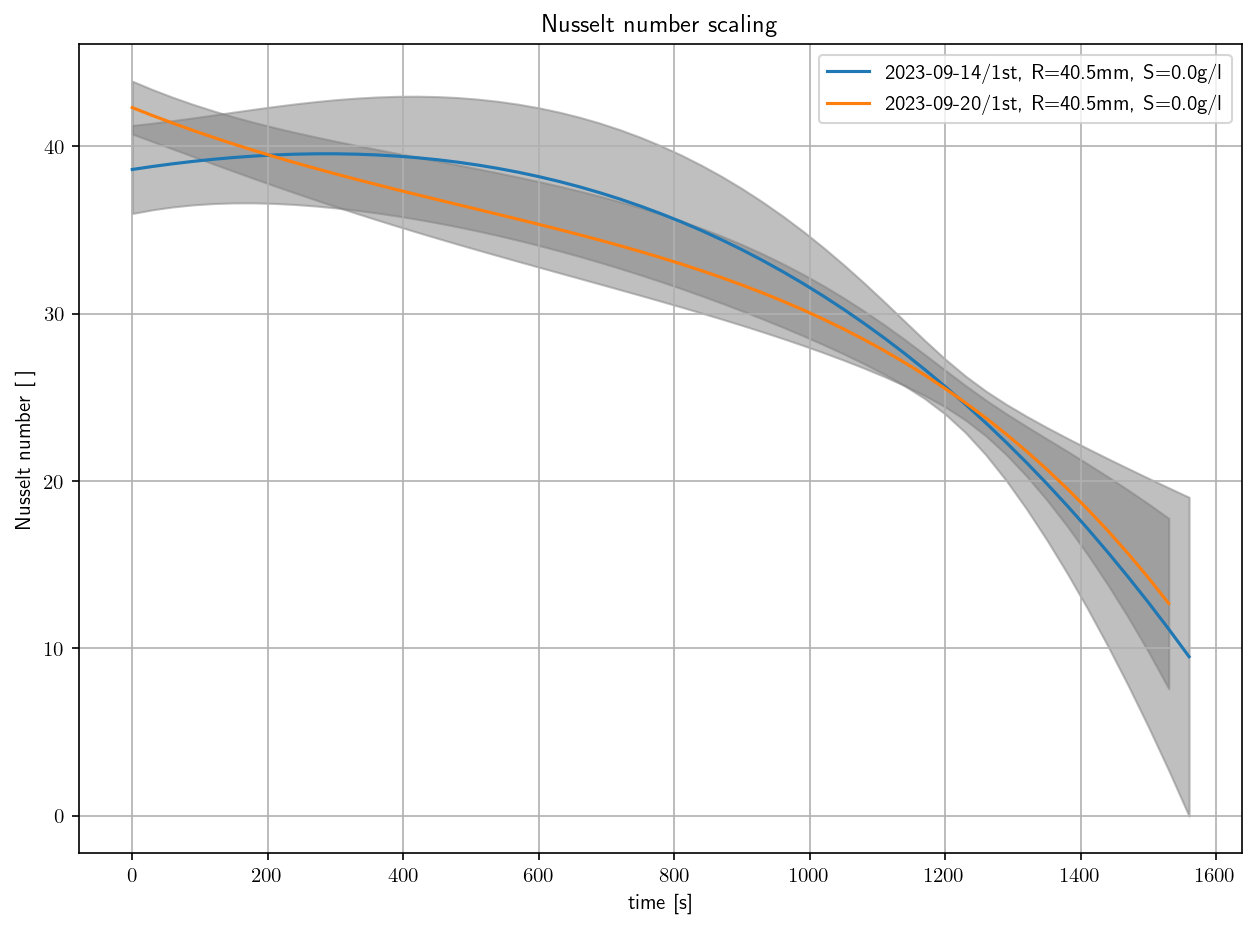

In [5]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd','2023-12-15/1st','2023-12-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-12-01/2nd','2023-12-04/1st']# D2O

plt.figure(figsize=(10,7),dpi=150)
plt.rcParams['text.usetex'] = True

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    # print(contours_per_shot)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10

    if exp_radius!=0.0405 : continue
    if exp_sal!=0.0 : continue

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)
    
    radii = correct_outliers(radii)

    x = contours_per_shot*interval*np.arange(len(radii))
    result, sigma = fit(func=f'np.polyval([a,b,c,{radii[0]}],x)',xdata=x,ydata=radii,draw=False,boolRetSigmas=True)
    uNusselt_numbers = uNu_fit(params=result['params'],t=x,r0=radii[0],T_water=exp_wt)
    value = np.array([i.nominal_value for i in uNusselt_numbers])
    std = np.array([i.std_dev for i in uNusselt_numbers])
    plt.plot(x,value,label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') 
    plt.fill_between(x,value+std,value-std,color='grey',alpha=0.5)
    
    # # only for bootstrapping
    # areas_fit = np.pi*result['func'](x)**2
    # uareas = unumpy.uarray(areas_fit,sigma)
    # Nusselt_numbers = uNu_areas(uareas,exp_wt,interval*contours_per_shot)
    # # error band with bootstrapping
    # for i in range(1000):
    #     a,b,c = bootstrap(result=result)
    #     if i==0: band = Nu_areas(np.pi*np.polyval([a,b,c,radii[0]],x)**2,exp_wt,interval*contours_per_shot) # these are areas that get fed to the nusselt number calculator
    #     band = np.vstack((band,Nu_areas(np.pi*np.polyval([a,b,c,radii[0]],x)**2,exp_wt,interval*contours_per_shot)))
    # std_band = np.std(band,axis=0)
    # a,b,c = result['params']['a']['value'],result['params']['b']['value'],result['params']['c']['value']
    # best_fit = Nu_areas(np.pi*np.polyval([a,b,c,d],x)**2,exp_wt,interval*contours_per_shot)
    # plt.fill_between(x,best_fit+std_band,best_fit-std_band,
    #                  color='grey',alpha=0.5)
    
plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Nusselt number [ ]')
plt.title('Nusselt number scaling')

plt.show()

# Nusselt vs Rayleigh

3


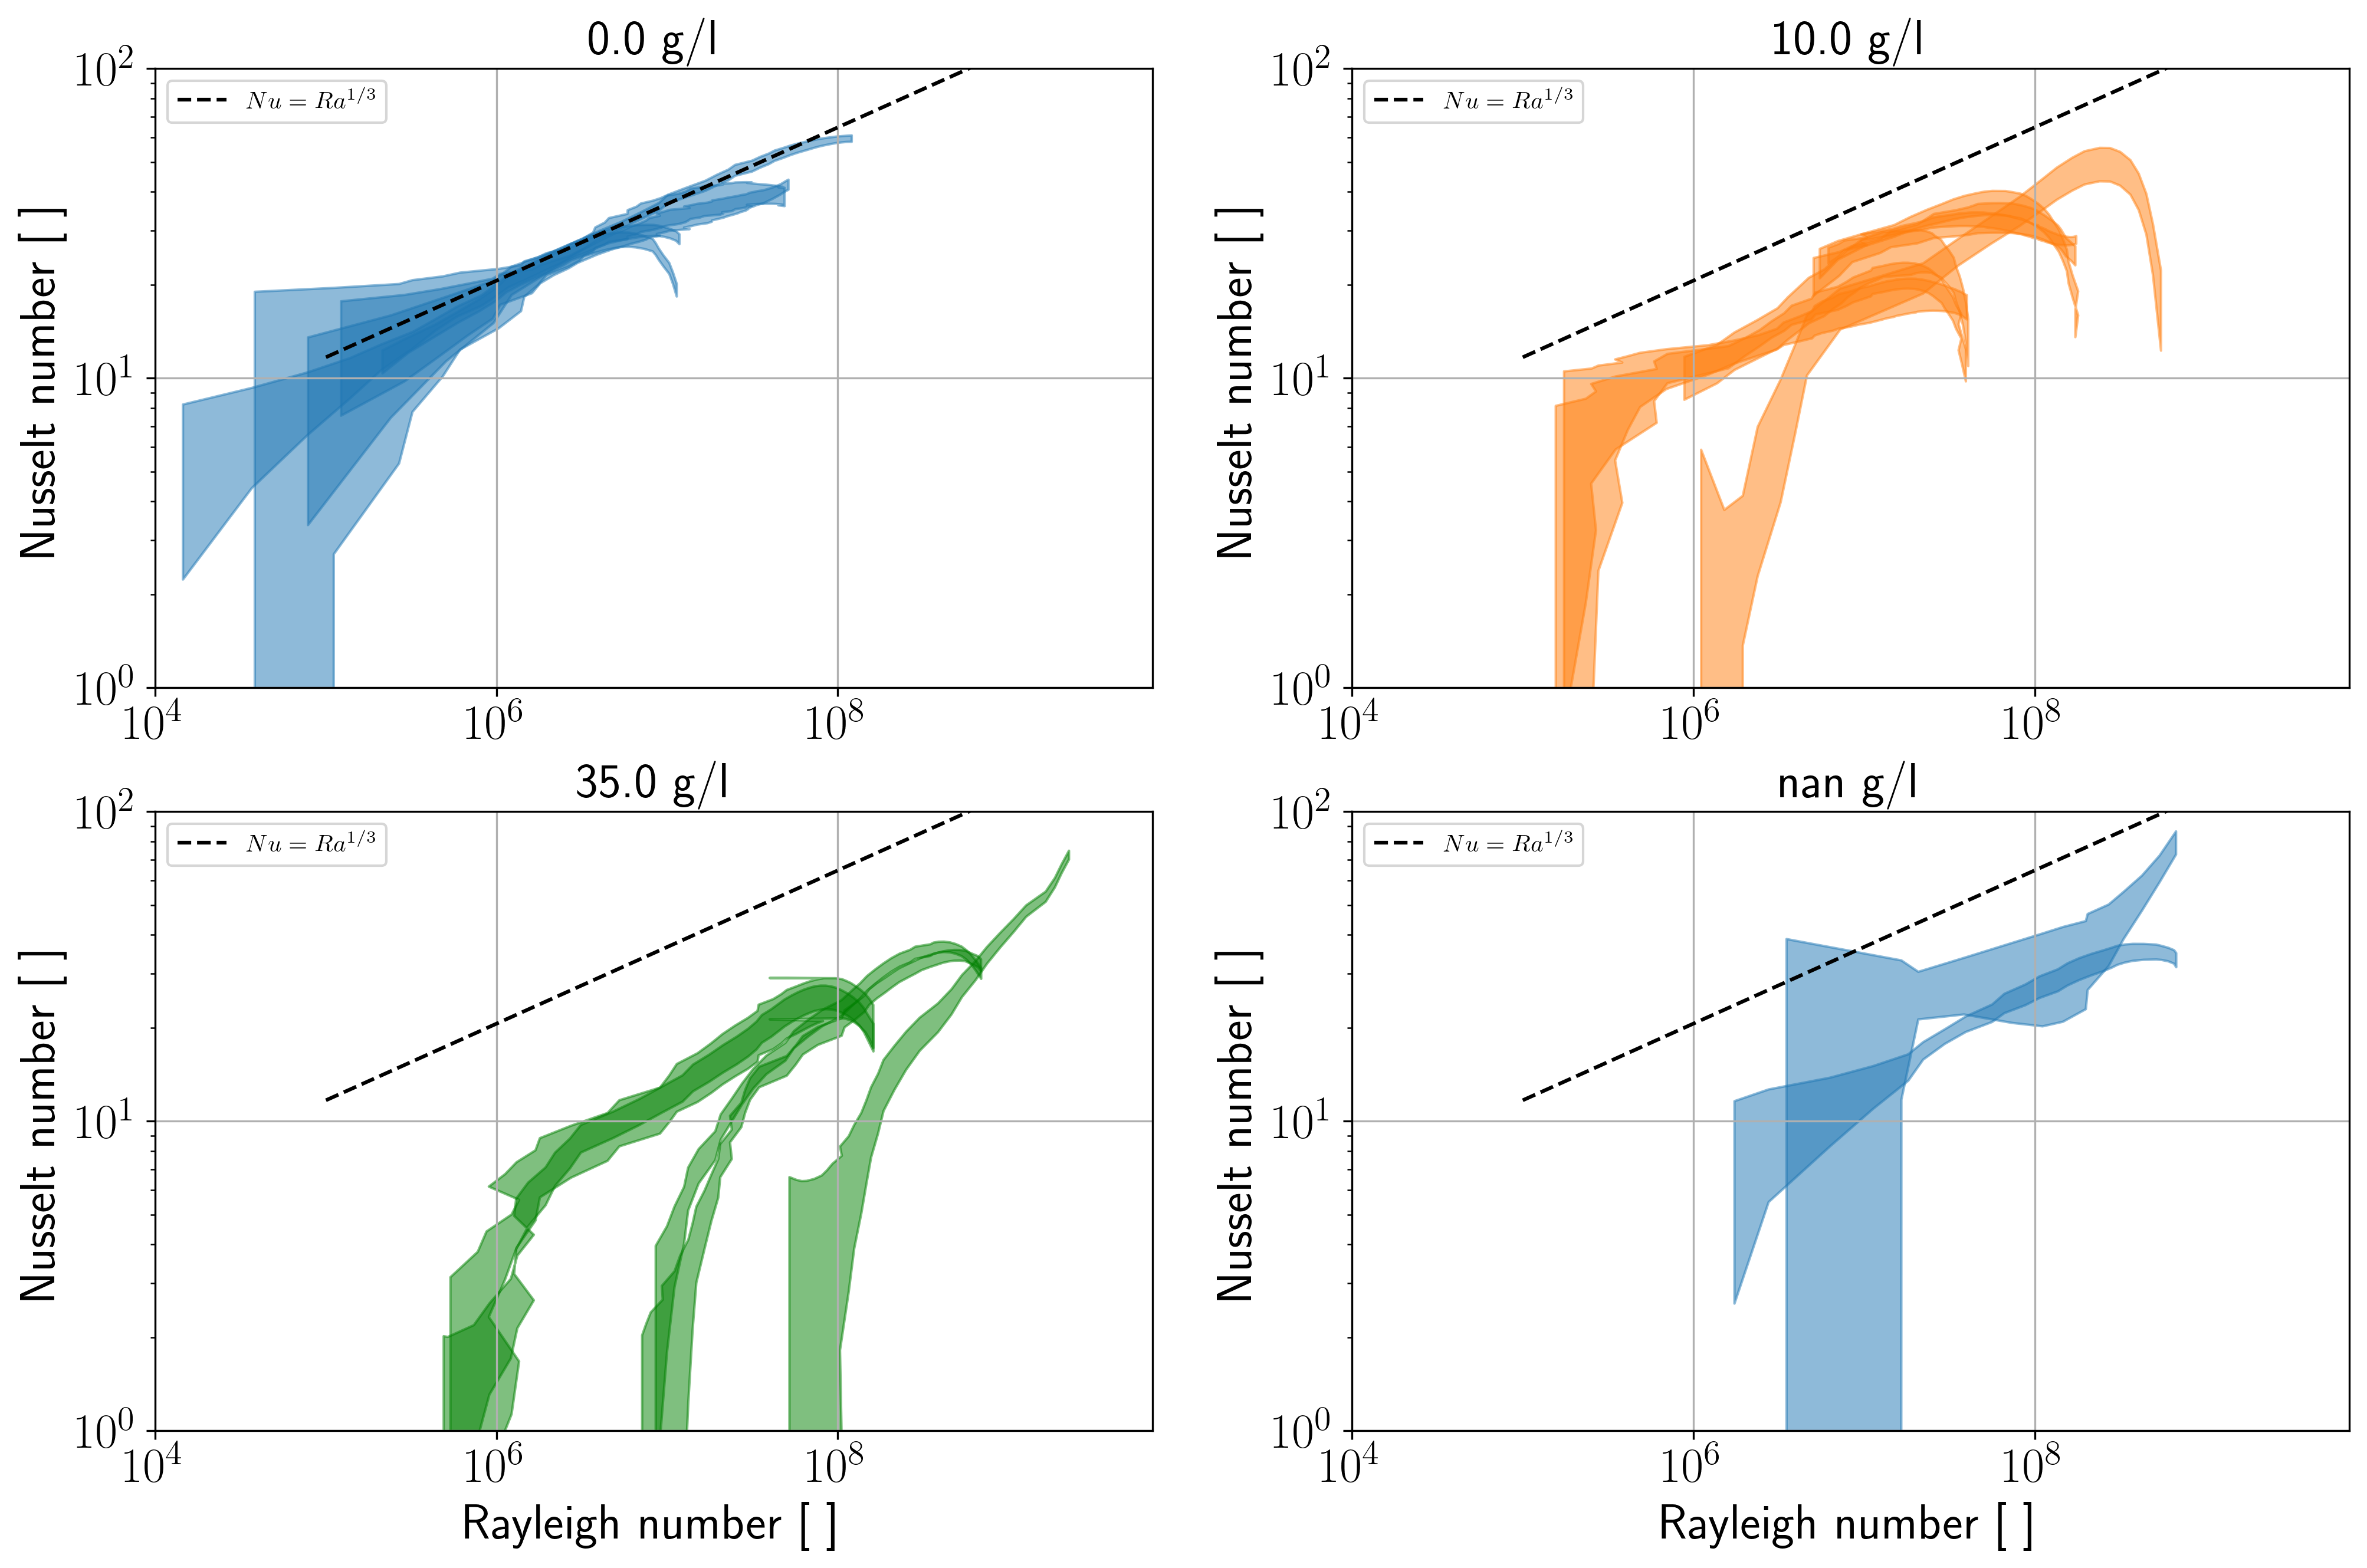

In [ ]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd','2023-12-15/1st','2023-12-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-12-01/2nd','2023-12-04/1st']# D2O

chosen_radii = [0.025,0.0405,0.06]
chosen_salts = [0.,10.,35.,]

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(16,10),dpi=300)
plt.rcParams['text.usetex'] = True

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    if cylinder=='2023-12-08/1st': print(contours_per_shot)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10

    radii = []
    for it,contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            initialArea = np.pi*exp_radius**2 # px
            conversion = PolyArea(contour[:,1],contour[:,0])/initialArea # px/m2
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
        radii.append(radius)    
    
    radii = correct_outliers(radii)

    conversion = info[1,1]/radii[0] # m/px
    radii = np.array(radii)
    radii *= conversion

    if exp_sal == 0.:
        axi = ax.flatten()[0]
    elif exp_sal == 10.:
        axi = ax.flatten()[1]
    elif exp_sal == 35.:
        axi = ax.flatten()[2]
    elif np.isnan(exp_sal):
        axi = ax.flatten()[3]

    Rayleigh_numbers = Ra_salinity(radii,0,exp_wt,S=exp_sal)
    if np.isnan(exp_sal): Rayleigh_numbers=Ra_heavyWater(radii,exp_wt)
    
    x = contours_per_shot*interval*np.arange(len(radii))
    result, sigma = fit(func=f'np.polyval([a,b,c,{radii[0]}],x)',xdata=x,ydata=radii,draw=False,boolRetSigmas=True)
    uNusselt_numbers = uNu_fit(params=result['params'],t=x,r0=radii[0],T_water=exp_wt)
    value = np.array([i.nominal_value for i in uNusselt_numbers])
    std = np.array([i.std_dev for i in uNusselt_numbers])
    # axi.scatter(Rayleigh_numbers,value,
    #             label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l',zorder=100,
    #             marker=myMarkers[np.where(chosen_radii==find_nearest(chosen_radii,exp_radius))[0][0]],
    #             edgecolor=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]],
    #             facecolor='none')
    axi.fill_between(Rayleigh_numbers,value+std,value-std,
                     color=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]],
                     alpha=0.5)
    axi.set_title(f'{exp_sal} g/l',fontsize=20)
    

for axi in ax.flatten():
    axi.plot(np.logspace(5,9,50),25*np.logspace(-1,2,50)**.33,linestyle='--',c='k',label=r'$Nu=Ra^{1/3}$')
    # axi.plot(np.logspace(5,9,50),25*np.logspace(-1,2,50)**.25,linestyle='-.',c='k',label='.25')
    axi.grid()
    axi.legend()
    axi.set_ylabel('Nusselt number [ ]',fontsize=20)
    axi.set_xlabel('Rayleigh number [ ]',fontsize=20)
    if axi == ax.flatten()[0] or axi == ax.flatten()[1]:
        axi.set_xlabel('')

    axi.set_yscale('log')
    axi.set_xlim(1e4,7e9)
    axi.set_xscale('log')
    axi.set_ylim(1e0,1e2)

    axi.tick_params(axis='x', labelsize=20)
    axi.tick_params(axis='y', labelsize=20)

# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/NuRa.eps',format='eps',bbox_inches='tight')
plt.show()